In [1]:
import numpy as np
import pandas as pd
from data import Stock
from analysis import Analysis
from hidden_markov_model import Hidden_Markov_Model

In [2]:
sa40 = Stock('JTOPI')
sa40.series_data = pd.read_csv('South_Africa_Top_40_Historical_Data.csv')
sa40.preprocess()

analysis = Analysis()
analysis.add_log_return(sa40)
sa40.series_data.dropna(inplace=True)

In [3]:
model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 2)
model.baum_welch_algorithm(0.001, 100)

Iteration 1 . . . Log-Likelihood = 3829.636281990243
Iteration 2 . . . Log-Likelihood = 3829.669938000772
Iteration 3 . . . Log-Likelihood = 3830.4815465014485
Iteration 4 . . . Log-Likelihood = 3840.1800181706867
Iteration 5 . . . Log-Likelihood = 3865.07123657756
Iteration 6 . . . Log-Likelihood = 3887.512384276648
Iteration 7 . . . Log-Likelihood = 3901.415770139969
Iteration 8 . . . Log-Likelihood = 3909.1397309636372
Iteration 9 . . . Log-Likelihood = 3913.705043341556
Iteration 10 . . . Log-Likelihood = 3916.927505362939
Iteration 11 . . . Log-Likelihood = 3919.6691913378572
Iteration 12 . . . Log-Likelihood = 3922.2916440234158
Iteration 13 . . . Log-Likelihood = 3924.933234317491
Iteration 14 . . . Log-Likelihood = 3927.6407118385423
Iteration 15 . . . Log-Likelihood = 3930.424227265543
Iteration 16 . . . Log-Likelihood = 3933.2787909201884
Iteration 17 . . . Log-Likelihood = 3936.1923929322593
Iteration 18 . . . Log-Likelihood = 3939.149129384904
Iteration 19 . . . Log-Likelih

In [4]:
model.get_parameters()

==================================== 0 =====================================
Initial Probability: 9.21543083367338e-46
Mean: 9.104073323603643e-05
Variance: 0.0006579815342227062


==================================== 1 =====================================
Initial Probability: 1.0
Mean: 0.0004596175637836175
Variance: 9.842383419820172e-05


Transition Matrix: [[0.93512431 0.06487569]
 [0.01046348 0.98953652]]
Log Likelihood: 3989.6056793902953


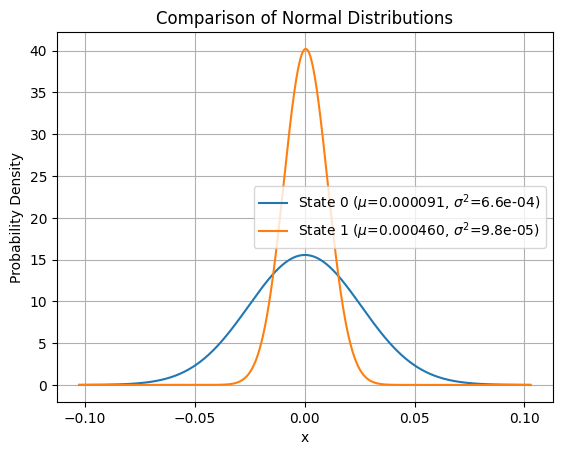

In [5]:
mean_array, variance_array = model.get_mean_variance()

analysis.plot_distributions(mean_array, variance_array)

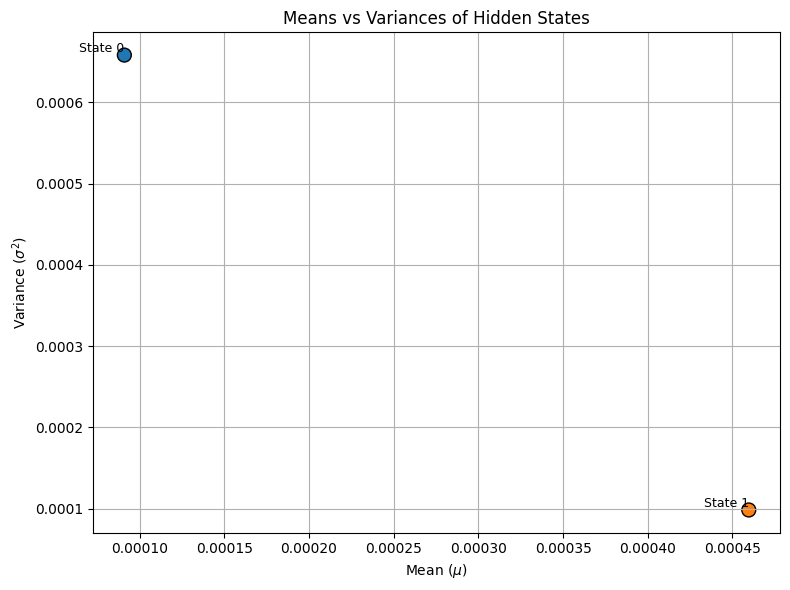

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_means_vs_variances(mean_array, variance_array):
    num_points = len(mean_array)
    colors = plt.cm.tab10(np.arange(num_points) % 10)  # Cycle through tab10 colors

    plt.figure(figsize=(8, 6))
    plt.scatter(mean_array, variance_array, c=colors, s=100, edgecolors='black')

    for i, (mu, var) in enumerate(zip(mean_array, variance_array)):
        plt.text(mu, var, f'State {i}', fontsize=9, ha='right', va='bottom')

    plt.title("Means vs Variances of Hidden States")
    plt.xlabel("Mean ($\\mu$)")
    plt.ylabel("Variance ($\\sigma^2$)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_means_vs_variances(mean_array, variance_array)

In [7]:
state_sequence = model.viterbi_algorithm()

In [8]:
state_sequence

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

def plot_price_with_states(stock, column, state_sequence):
    colours = ['red', 'green', 'yellow', 'blue']
    stock_data = stock.series_data[[column, 'Date']].copy()
    stock_data = stock_data.reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(stock_data['Date'], stock_data[column], label=column, color='black')

    legend_handles = {}

    current_state = state_sequence[0]
    start_idx = 0

    for t in range(1, len(state_sequence)):
        if state_sequence[t] != current_state or t == len(state_sequence) - 1:
            end_idx = t if state_sequence[t] != current_state else t + 1
            color = colours[current_state % len(colours)] # Use modulo to handle cases with more states than colors
            label = f"State {current_state}"
            if current_state not in legend_handles:
                ax.axvspan(stock_data['Date'][start_idx], stock_data['Date'][end_idx - 1],
                           color=color, alpha=0.2, label=label)
                legend_handles[current_state] = True
            else:
                ax.axvspan(stock_data['Date'][start_idx], stock_data['Date'][end_idx - 1],
                           color=color, alpha=0.2)
            current_state = state_sequence[t]
            start_idx = t

    color = colours[current_state % len(colours)]
    label = f"State {current_state}"
    ax.axvspan(stock_data['Date'][start_idx], stock_data['Date'][len(stock_data) - 1],
               color=color, alpha=0.2, label=label if current_state not in legend_handles else None)
    legend_handles[current_state] = True

    ax.set_title(f"{stock.ticker} {column} with Hidden States")
    ax.set_xlabel("Date")
    ax.set_ylabel(column)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    plt.show()


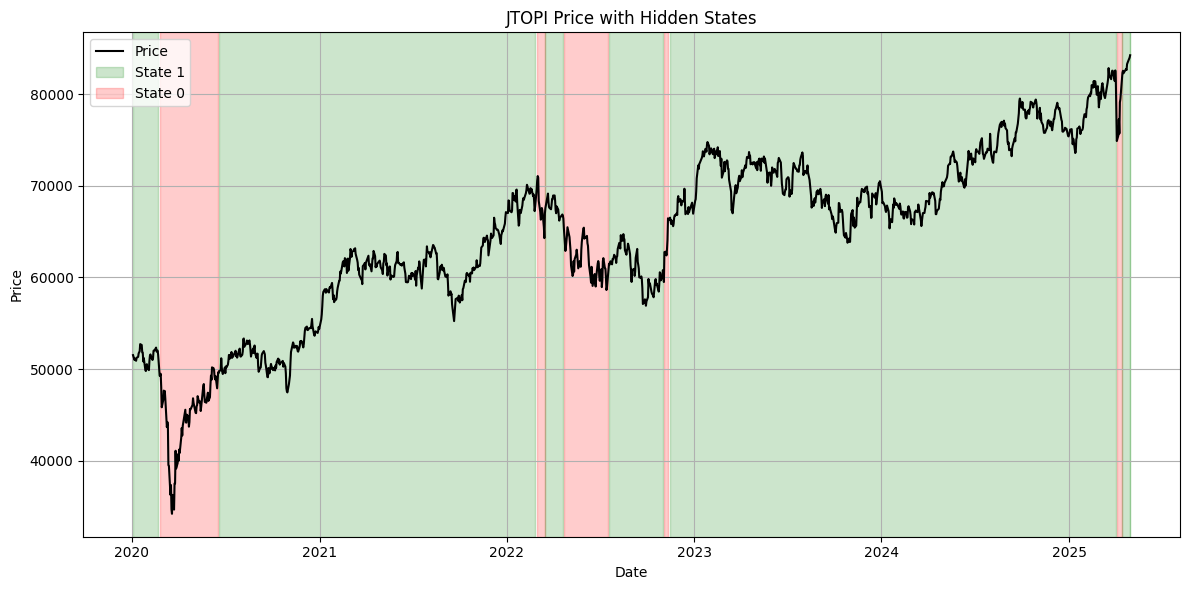

In [10]:
plot_price_with_states(sa40, 'Price', state_sequence)